# ch 16_7 SARIMA

이번 챕터에서는 ARIMA 모델이 계절성을 반영할 수 있도록 보완한 Seasonal ARIMA에 대해서 배워보겠습니다.

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

## 데이터 셋 준비

In [2]:
from utils import load_air_passengers

train_df, test_df = load_air_passengers()

<Axes: xlabel='Month'>

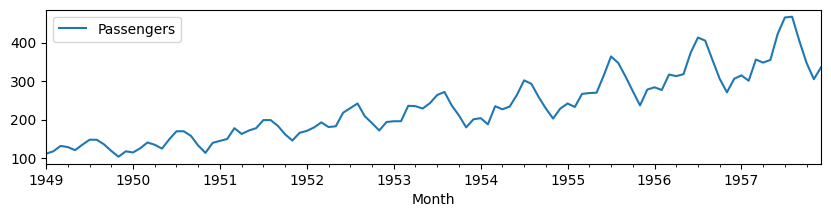

In [3]:
train_df.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

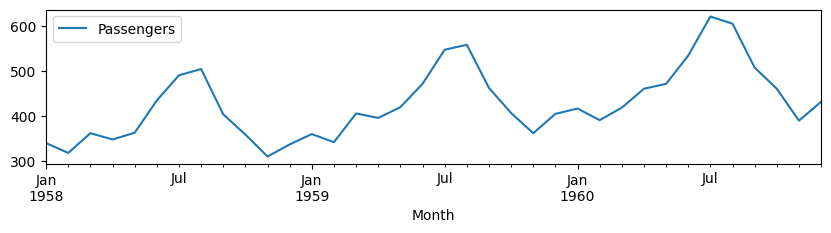

In [4]:
test_df.plot(figsize=(10, 2))

### 계절성 확인

plot_acf를 이용해서 데이터의 계절성을 확인해보겠습니다. 12개월 주기로 spike가 발생하므로, 계절성의 주기가 12임을 알 수 있습니다.

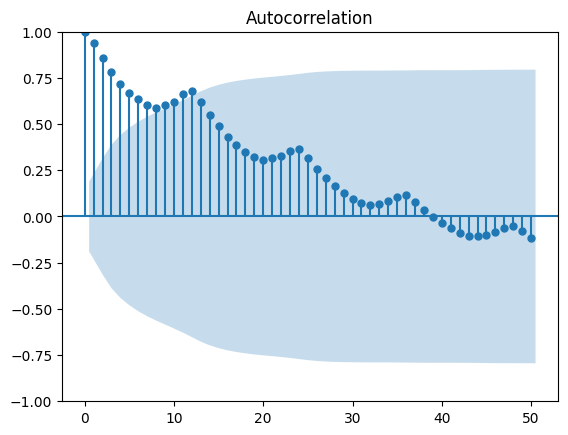

In [7]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train_df["Passengers"], lags=50);

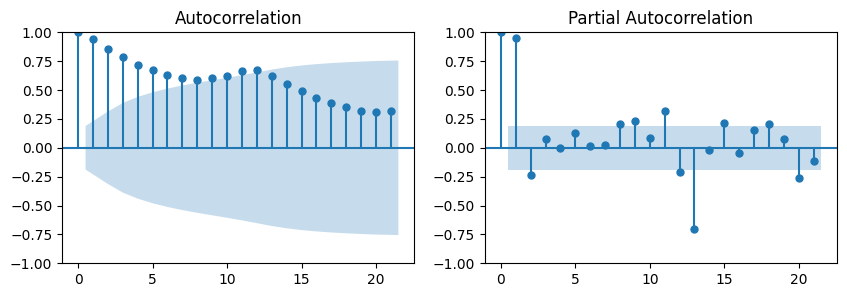

In [5]:
from utils import plot_acf_pacf

plot_acf_pacf(train_df, "Passengers")

### Seasonal Difference

데이터가 계절성을 띈다면 ARIMA 처럼 단순 차분을 적용하는 것이 적합하지 않을 수 있습니다. 이런 경우, 계절 차분을 사용하는 Seasonal ARIMA 모델을 사용할 수 있습니다. 

바로 이전 시점의 값을 빼주는 차분과 달리 계절 차분은 이전 계절의 값을 빼주면 됩니다. 탑승객 데이터의 계절성은 12개월이라고 가정하고, 단순 차분과 계절 차분을 비교해보겠습니다.

In [8]:
train_df["diff"] = train_df["Passengers"].diff()
train_df["seasonal_diff"] = train_df["Passengers"].diff(12)

<Axes: xlabel='Month'>

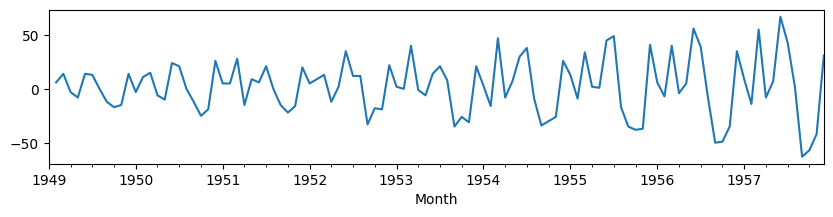

In [9]:
train_df["diff"].plot(figsize=(10, 2))

<Axes: xlabel='Month'>

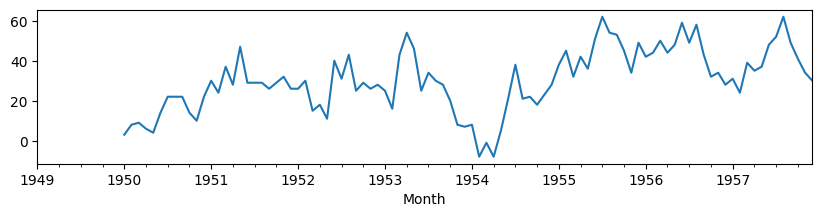

In [10]:
train_df["seasonal_diff"].plot(figsize=(10, 2))

단순 차분을 할 경우, 계절성이 유지되는 모습을 확인할 수 있습니다. 반면에 계절 차분을 적용할 경우, 계절성이 제거된 것을 확인할 수 있습니다.

### ARIMA 모델 학습

비교를 위해서 auto_arima를 이용하여 ARIMA 모델을 학습시키겠습니다.

In [11]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(
    train_df["Passengers"],
    seasonal=False,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.03 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 0.967 seco

## SARIMA 모델 학습

### 수작업으로 SARIMA 모델 파라미터 찾기

SARIMA 모델은 계절 차분을 사용하는 ARIMA 모델입니다. SARIMA는 ARIMA의 p, d, q 세 파라미터에 더해 P, D, Q 파라미터가 추가됩니다. 이는 각각 계절성을 반영한 P,  D, Q를 의미합니다.

- P: 계절 차분을 적용한 데이터의 PACF 플랏에서 가장 높은 유의한 지연으로 설정합니다. 예제에서는 1을 사용합니다.
- D: 데이터가 계절성을 보이지 않으면 0으로 설정합니다. 분명한 계절성을 보이면 1로 설정합니다.
- Q: 계절 차분을 적용한 데이터의 ACF 플랏에서 유의한 지연수로 설정합니다.

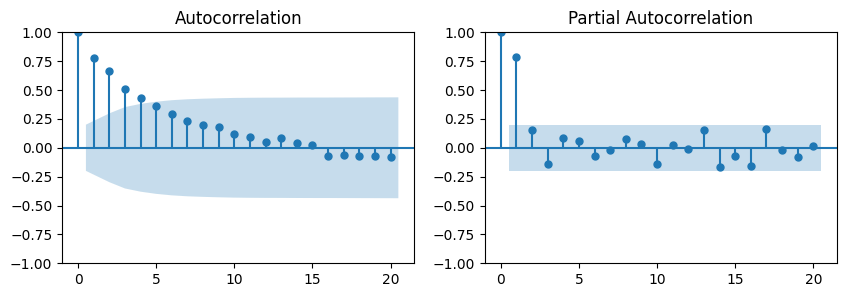

In [12]:
from utils import plot_acf_pacf

plot_acf_pacf(train_df, "seasonal_diff")

SARIMA 모델 파라미터 중 p, d, q는 (2, 1, 1)로 설정하겠습니다. SARIMA 모델의 파라미터 중 P, D, Q, m은 (1, 1, 4, 12)로 설정하겠습니다.

In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_df["Passengers"],
    order=(2, 1, 1),
    seasonal_order=(1, 1, 4, 12)
).fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26812D+00    |proj g|=  2.26994D-01

At iterate    5    f=  3.21325D+00    |proj g|=  1.02028D-02

At iterate   10    f=  3.19820D+00    |proj g|=  2.84680D-02

At iterate   15    f=  3.19432D+00    |proj g|=  1.10309D-02

At iterate   20    f=  3.19184D+00    |proj g|=  7.97038D-03

At iterate   25    f=  3.19147D+00    |proj g|=  1.70383D-03

At iterate   30    f=  3.19144D+00    |proj g|=  6.45248D-05

At iterate   35    f=  3.19144D+00    |proj g|=  5.33996D-04

At iterate   40    f=  3.19143D+00    |proj g|=  1.10582D-03

At iterate   45    f=  3.19142D+00    |proj g|=  5.31155D-04


/Users/user/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  3.19142D+00    |proj g|=  9.82966D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   9.830D-05   3.191D+00
  F =   3.1914183833059231     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [14]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                                    Passengers   No. Observations:                  108
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2, 3, 4], 12)   Log Likelihood                -344.673
Date:                                       Wed, 02 Aug 2023   AIC                            707.346
Time:                                               10:38:37   BIC                            730.331
Sample:                                           01-01-1949   HQIC                           716.634
                                                - 12-01-1957                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6141      1.717     -0.358      0.721      -3.979       2.751
ar.L2         -0.0339      0.526     -0.064      0.949      -1.064       0.996
ma.L1          0.3732      1.721      0.217      0.828      -2.999       3.745
ar.S.L12       0.9785      0.680      1.438      0.150      -0.355       2.312
ma.S.L12      -1.5176     21.473     -0.071      0.944     -43.604      40.569
ma.S.L24       0.3974     13.243      0.030      0.976     -25.558      26.352
ma.S.L36       0.0986      4.781      0.021      0.984      -9.272       9.469
ma.S.L48       0.1427      2.795      0.051      0.959      -5.335       5.621
sigma2        56.2373   1212.969      0.046      0.963   -2321.138    2433.612
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.01
Prob(Q):                              0.97   Prob(JB):                         0.37
Heteroskedasticity (H):               1.15   Skew:                             0.35
Prob(H) (two-sided):                  0.69   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 자동으로 SARIMA 모델 파라미터 찾기

auto_arima를 이용해서 AIRMA와 SARIMA 모델을 학습시켜보고, 결과를 비교해보겠습니다. auto_arima를 이용해서 SARIMA 모델의 파라미터를 찾고자 할 때 주의할 점이 있습니다. 
- seasonal: True로 설정하기
- m: 계절 차분에 적용할 값으로 앞서 찾은 주기 값 12
- D: 계절성 차분으로 데이터가 분명한 계절성을 보인다면 1로 설정할 것

In [15]:
auto_sarima_model = auto_arima(
    train_df["Passengers"],
    seasonal=True,
    m=12,
    D=1,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=706.671, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.730, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=704.186, Time=0.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=704.801, Time=0.29 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=704.001, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.472, Time=0.24 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.993, Time=0.37 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=705.691, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=705.081, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=704.376, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=707.075, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=705.875, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.408 seconds


### Inference
 
학습시킨 ARIMA, SARIMA 모델의 정확도를 비교하기 위해서 각각 예측값을 내려보겠습니다.

In [16]:
train_df["ARIMA"] = arima_model.predict_in_sample()
train_df["SARIMA"] = sarima_model.predict()
train_df["AUTO_SARIMA"] = auto_sarima_model.predict_in_sample()

In [20]:
train_df.head()

,Passengers,diff,seasonal_diff,ARIMA,SARIMA,AUTO_SARIMA
Month,,,,,,
1949-01-01,112,NaN,NaN,2.502112,0.000000,0.000000
1949-02-01,118,6.0,NaN,114.518892,111.998581,111.998670
1949-03-01,132,14.0,NaN,121.311390,118.000533,118.000178
1949-04-01,129,-3.0,NaN,137.131336,131.999347,131.999625
1949-05-01,121,-8.0,NaN,129.712023,129.000411,129.000162


In [17]:
test_df["ARIMA"] = arima_model.predict(n_periods=len(test_df))
test_df["SARIMA"] = sarima_model.forecast(steps=len(test_df))
test_df["AUTO_SARIMA"] = auto_sarima_model.predict(n_periods=len(test_df))

In [21]:
test_df.head()

,Passengers,ARIMA,SARIMA,AUTO_SARIMA
Month,,,,
1958-01-01,340,344.107615,347.395776,345.964471
1958-02-01,318,365.851594,330.115198,331.731920
1958-03-01,362,394.827343,387.597340,386.787992
1958-04-01,348,423.276576,381.072014,378.774472
1958-05-01,363,444.290989,389.903595,385.777732


### Visualize

예측 값이 실제 값과 얼마나 차이가 나는지 시각화 해보겠습니다.

(-216.0, -180.0)

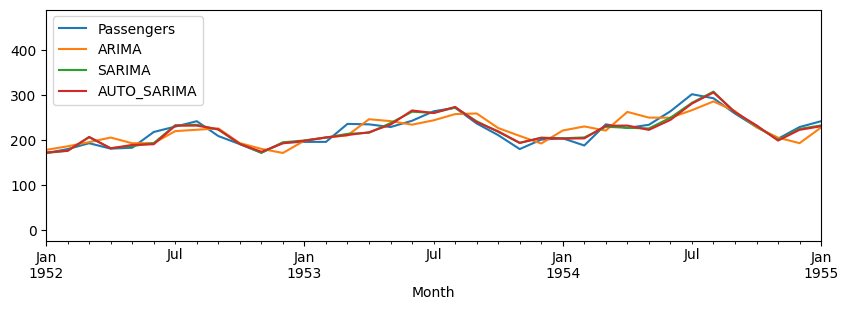

In [29]:
from matplotlib import pyplot as plt
import pandas as pd

train_df[["Passengers", "ARIMA", "SARIMA", "AUTO_SARIMA"]].plot(figsize=(10, 3))
plt.xlim(pd.Timestamp("1952-01-01"), pd.Timestamp("1955-01-01"))

<Axes: xlabel='Month'>

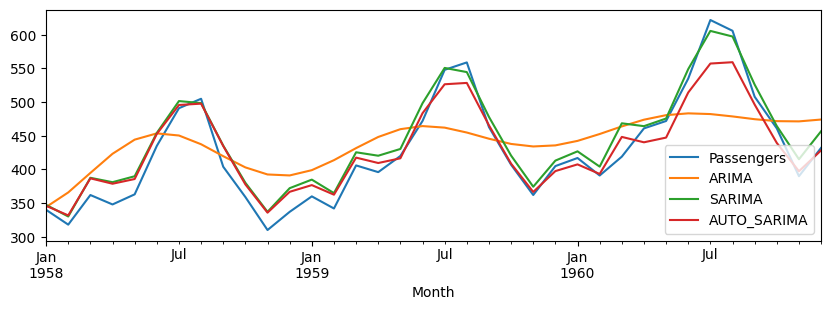

In [30]:
test_df[["Passengers", "ARIMA", "SARIMA", "AUTO_SARIMA"]].plot(figsize=(10, 3))

육안으로 보기에도 SARIMA 모델이 ARIMA 모델보다 더 정확도가 높은 것을 알 수 있습니다.

### Metric 측정

정량적으로 어느 모델이 더 정확한지 메트릭을 측정해보겠습니다. 일반 ARIMA 모델 보다는 SARIMA 모델이 확실히 성능이 좋고, 수작업으로 파라미터를 결정한 모델이 성능이 근소하게 뛰어납니다.

In [31]:
from utils import calculate_rmse

calculate_rmse(test_df, "Passengers", "ARIMA")
calculate_rmse(test_df, "Passengers", "SARIMA")
calculate_rmse(test_df, "Passengers", "AUTO_SARIMA")

ARIMA RMSE: 59.206158726932685
SARIMA RMSE: 20.56782910733024
AUTO_SARIMA RMSE: 22.132236740172


## 정리

이번 챕터에서는 ARIMA 모델에 계절성을 반영한 SARIMA 모델을 배워봤습니다. 계절성을 뚜렷하게 보여주는 Passengers 데이터에 적용해보니 명확한 성능 개선 효과를 보여주었습니다.